In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2S, DenseNet201, ResNet50V2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

In [2]:
# Define dataset directories
dataset_dir = "images\images"

In [3]:
# Image size & batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [4]:
import os
print(os.listdir(dataset_dir))


['aerosol_cans', 'aluminum_food_cans', 'aluminum_soda_cans', 'cardboard_boxes', 'cardboard_packaging', 'clothing', 'coffee_grounds', 'disposable_plastic_cutlery', 'eggshells', 'food_waste', 'glass_beverage_bottles', 'glass_cosmetic_containers', 'glass_food_jars', 'magazines', 'newspaper', 'office_paper', 'paper_cups', 'plastic_cup_lids', 'plastic_detergent_bottles', 'plastic_food_containers', 'plastic_shopping_bags', 'plastic_soda_bottles', 'plastic_straws', 'plastic_trash_bags', 'plastic_water_bottles', 'shoes', 'steel_food_cans', 'styrofoam_cups', 'styrofoam_food_containers', 'tea_bags']


In [5]:

def build_img_dataset(dataset_dir, split_ratio=(0.7, 0.2, 0.1)):
    all_images = []
    all_labels = []
    class_names = sorted(os.listdir(dataset_dir))

    for class_idx, class_name in enumerate(class_names):
        class_path = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_path):
            for subfolder in ['default', 'real_world']:
                subfolder_path = os.path.join(class_path, subfolder)
                if os.path.exists(subfolder_path):
                    for img_name in os.listdir(subfolder_path):
                        img_path = os.path.join(subfolder_path, img_name)
                        all_images.append(img_path)
                        all_labels.append(class_idx)

    print(f"Total images collected: {len(all_images)}")
    print(f"Sample images: {all_images[:5]}")  # Print first 5 images
    
    
    return all_images, all_labels, class_names

# Call function
all_images, all_labels, class_names = build_img_dataset(dataset_dir)


Total images collected: 15000
Sample images: ['images\\images\\aerosol_cans\\default\\Image_1.png', 'images\\images\\aerosol_cans\\default\\Image_10.png', 'images\\images\\aerosol_cans\\default\\Image_100.png', 'images\\images\\aerosol_cans\\default\\Image_101.png', 'images\\images\\aerosol_cans\\default\\Image_102.png']


In [6]:
import os
from sklearn.model_selection import train_test_split

def build_img_dataset(dataset_dir, split_ratio=(0.7, 0.2, 0.1)):
    all_images = []
    all_labels = []
    class_names = sorted(os.listdir(dataset_dir))

    for class_idx, class_name in enumerate(class_names):
        class_path = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_path):
            for subfolder in ['default', 'real_world']:
                subfolder_path = os.path.join(class_path, subfolder)
                if os.path.exists(subfolder_path):
                    for img_name in os.listdir(subfolder_path):
                        img_path = os.path.join(subfolder_path, img_name)
                        all_images.append(img_path)
                        all_labels.append(class_idx)

    print(f"Total images collected: {len(all_images)}")
    print(f"Sample images: {all_images[:5]}")  # Print first 5 images

    # Check if dataset is empty
    if len(all_images) == 0:
        print("Error: No images found. Check dataset path and structure.")
        return None, None, None, None, None, None, None

    # Split dataset
    X_train, X_temp, y_train, y_temp = train_test_split(
        all_images, all_labels, test_size=1 - split_ratio[0], stratify=all_labels
    )
    X_valid, X_test, y_valid, y_test = train_test_split(
        X_temp, y_temp, test_size=split_ratio[2] / (split_ratio[1] + split_ratio[2]), stratify=y_temp
    )

    return X_train, y_train, X_valid, y_valid, X_test, y_test, class_names

# Call function
X_train, y_train, X_valid, y_valid, X_test, y_test, class_names = build_img_dataset(dataset_dir)

# Check if dataset was loaded properly
if X_train is not None:
    print(f"Train: {len(X_train)}, Valid: {len(X_valid)}, Test: {len(X_test)}")


Total images collected: 15000
Sample images: ['images\\images\\aerosol_cans\\default\\Image_1.png', 'images\\images\\aerosol_cans\\default\\Image_10.png', 'images\\images\\aerosol_cans\\default\\Image_100.png', 'images\\images\\aerosol_cans\\default\\Image_101.png', 'images\\images\\aerosol_cans\\default\\Image_102.png']
Train: 10499, Valid: 3000, Test: 1501


In [7]:
def create_datagen(X, y, augment=False):
    datagen = ImageDataGenerator(
        rescale=1.0/255,
        rotation_range=20 if augment else 0,
        horizontal_flip=True if augment else False,
        brightness_range=[0.8, 1.2] if augment else None
    )
    
    # Convert integer labels to corresponding class names
    y_str = [class_names[label] for label in y]  
    
    return datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({"filename": X, "label": y_str}),  # Use string labels
        x_col="filename",
        y_col="label",
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode="categorical"
    )


In [8]:
# Prepare datasets
train_data = create_datagen(X_train, y_train, augment=True)
valid_data = create_datagen(X_valid, y_valid)
test_data = create_datagen(X_test, y_test)

Found 10499 validated image filenames belonging to 30 classes.
Found 3000 validated image filenames belonging to 30 classes.
Found 1501 validated image filenames belonging to 30 classes.


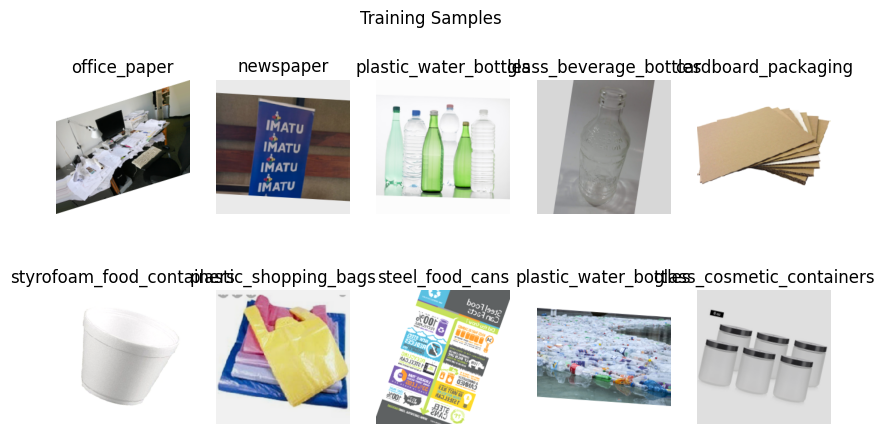

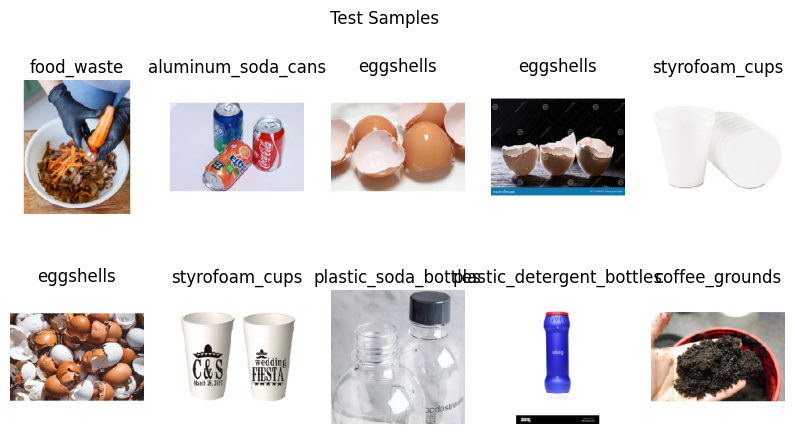

In [9]:
# Visualizing dataset
def visualize_data(data_gen, title):
    plt.figure(figsize=(10, 5))
    images, labels = next(data_gen)
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

visualize_data(train_data, "Training Samples")
visualize_data(test_data, "Test Samples")

In [10]:
# Function to build model
def build_model(base_model):
    base_model.trainable = False  # Freeze base model
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.4)(x)
    output_layer = Dense(len(class_names), activation="softmax")(x)
    return Model(inputs=base_model.input, outputs=output_layer)

# Models to train
models = {
    "EfficientNetV2": build_model(EfficientNetV2S(weights="imagenet", include_top=False, input_shape=(224, 224, 3))),
    "DenseNet201": build_model(DenseNet201(weights="imagenet", include_top=False, input_shape=(224, 224, 3))),
    "ResNet50V2": build_model(ResNet50V2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))),
}


Training EfficientNetV2...



c:\Users\anuha\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 737s 2s/step - accuracy: 0.0799 - loss: 3.3280 - val_accuracy: 0.1530 - val_loss: 3.0787
Epoch 2/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 649s 2s/step - accuracy: 0.1297 - loss: 3.1363 - val_accuracy: 0.1677 - val_loss: 2.9860
Epoch 3/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 755s 2s/step - accuracy: 0.1628 - loss: 3.0485 - val_accuracy: 0.1847 - val_loss: 2.9132
Epoch 4/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 699s 2s/step - accuracy: 0.1595 - loss: 3.0127 - val_accuracy: 0.2003 - val_loss: 2.8550
Epoch 5/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 654s 2s/step - accuracy: 0.1620 - loss: 2.9591 - val_accuracy: 0.2137 - val_loss: 2.8283
Epoch 6/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 670s 2s/step - accuracy: 0.1773 - loss: 2.9508 - val_accuracy: 0.2200 - val_loss: 2.7840
Epoch 7/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 681s 2s/step - accuracy: 0.1870 - loss: 2.9143 - val_accuracy: 0.2257 - val_loss: 2.7636
Epoch 8/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 610s 2s/step - accuracy: 0.1963 - loss: 2.8775 - val_accu

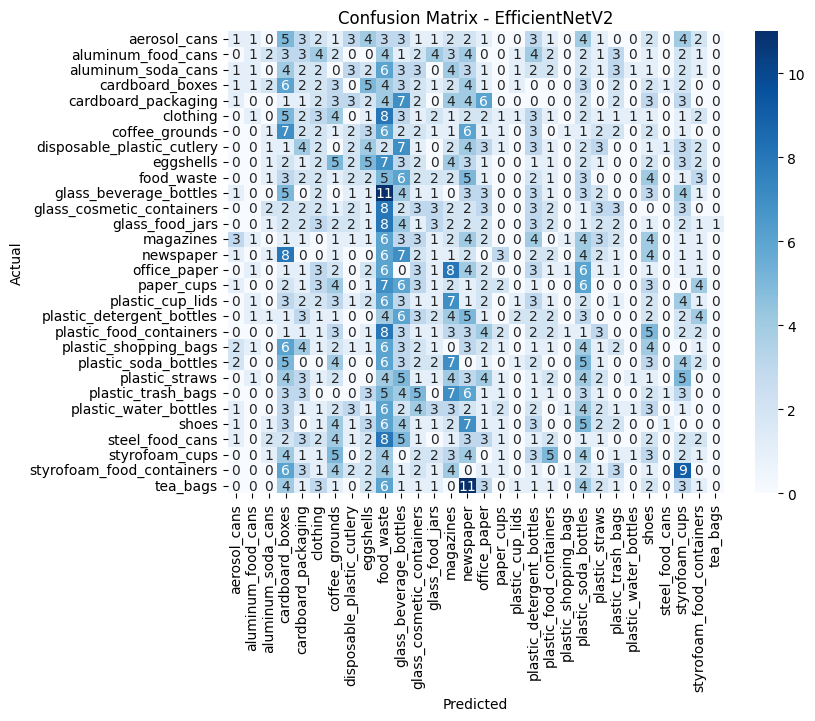

Classification Report for EfficientNetV2:

                            precision    recall  f1-score   support

              aerosol_cans       0.06      0.02      0.03        50
        aluminum_food_cans       0.09      0.02      0.03        50
        aluminum_soda_cans       0.00      0.00      0.00        51
           cardboard_boxes       0.06      0.12      0.08        50
       cardboard_packaging       0.02      0.02      0.02        50
                  clothing       0.06      0.06      0.06        50
            coffee_grounds       0.02      0.02      0.02        50
disposable_plastic_cutlery       0.06      0.04      0.05        50
                 eggshells       0.09      0.10      0.10        50
                food_waste       0.03      0.10      0.04        50
    glass_beverage_bottles       0.04      0.08      0.05        50
 glass_cosmetic_containers       0.05      0.06      0.05        50
           glass_food_jars       0.08      0.06      0.07        50
    

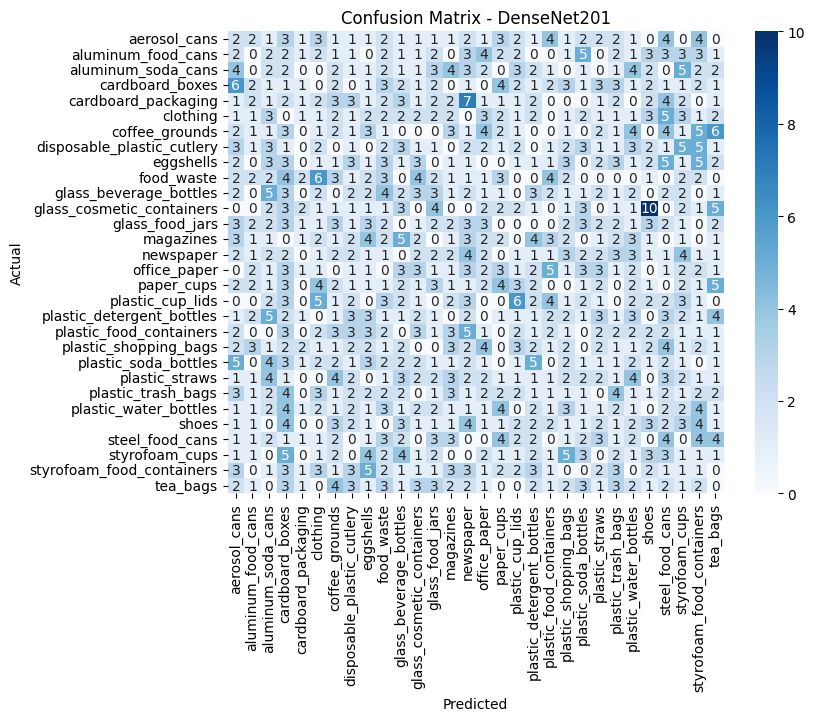

Classification Report for DenseNet201:

                            precision    recall  f1-score   support

              aerosol_cans       0.03      0.04      0.04        50
        aluminum_food_cans       0.00      0.00      0.00        50
        aluminum_soda_cans       0.04      0.04      0.04        51
           cardboard_boxes       0.01      0.02      0.02        50
       cardboard_packaging       0.05      0.02      0.03        50
                  clothing       0.02      0.02      0.02        50
            coffee_grounds       0.04      0.04      0.04        50
disposable_plastic_cutlery       0.02      0.02      0.02        50
                 eggshells       0.02      0.02      0.02        50
                food_waste       0.05      0.06      0.06        50
    glass_beverage_bottles       0.04      0.04      0.04        50
 glass_cosmetic_containers       0.00      0.00      0.00        50
           glass_food_jars       0.04      0.04      0.04        50
       

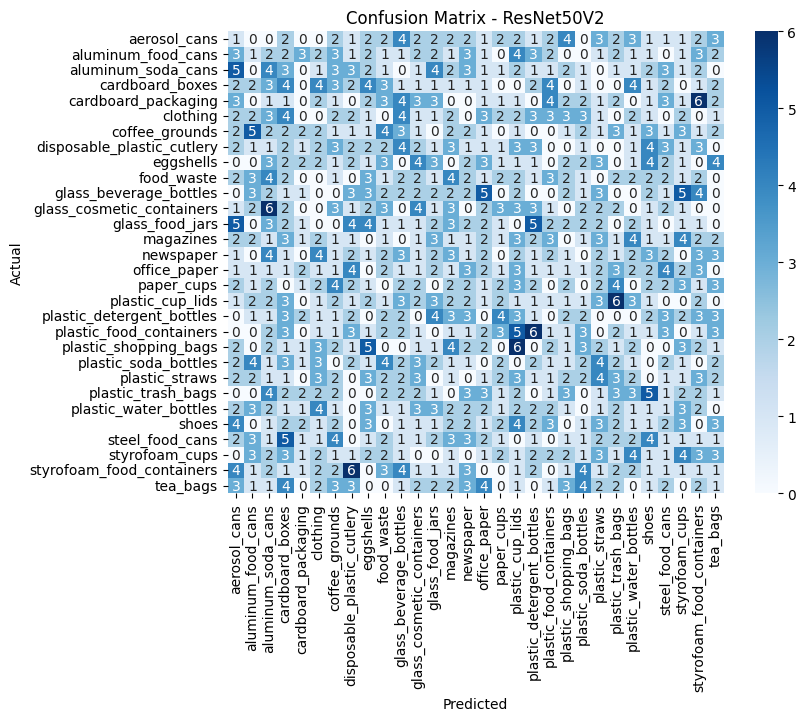

Classification Report for ResNet50V2:

                            precision    recall  f1-score   support

              aerosol_cans       0.02      0.02      0.02        50
        aluminum_food_cans       0.02      0.02      0.02        50
        aluminum_soda_cans       0.06      0.08      0.07        51
           cardboard_boxes       0.06      0.08      0.07        50
       cardboard_packaging       0.00      0.00      0.00        50
                  clothing       0.00      0.00      0.00        50
            coffee_grounds       0.02      0.02      0.02        50
disposable_plastic_cutlery       0.04      0.04      0.04        50
                 eggshells       0.02      0.02      0.02        50
                food_waste       0.02      0.02      0.02        50
    glass_beverage_bottles       0.04      0.04      0.04        50
 glass_cosmetic_containers       0.08      0.08      0.08        50
           glass_food_jars       0.04      0.04      0.04        50
        

In [11]:
# Training, Evaluation, and Plotting
history_dict = {}
for name, model in models.items():
    print(f"\nTraining {name}...\n")
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)
    
    history = model.fit(
        train_data,
        validation_data=valid_data,
        epochs=30,
        callbacks=[early_stopping]
    )
    
    history_dict[name] = history.history
    
    
    # Evaluate on train & test data
    train_loss, train_acc = model.evaluate(train_data)
    test_loss, test_acc = model.evaluate(test_data)
    print(f"\n{name} Train Accuracy: {train_acc:.4f}")
    print(f"{name} Test Accuracy: {test_acc:.4f}\n")

    # Confusion Matrix
    y_pred = np.argmax(model.predict(test_data), axis=1)
    y_true = test_data.classes

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    # Classification Report
    print(f"Classification Report for {name}:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

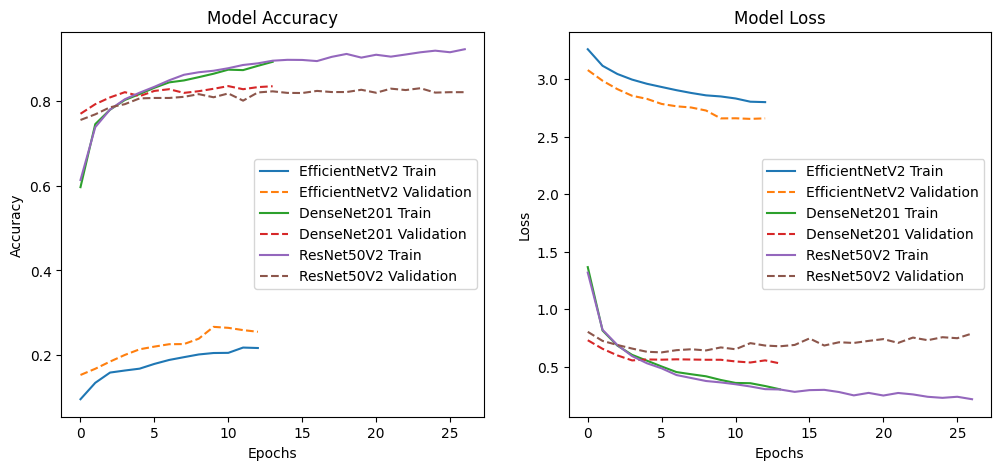

In [12]:
# Plot Accuracy & Loss Curves
def plot_curves(history_dict):
    plt.figure(figsize=(12, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    for name, hist in history_dict.items():
        plt.plot(hist["accuracy"], label=f"{name} Train")
        plt.plot(hist["val_accuracy"], linestyle="dashed", label=f"{name} Validation")
    plt.legend()
    plt.title("Model Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    
    # Loss plot
    plt.subplot(1, 2, 2)
    for name, hist in history_dict.items():
        plt.plot(hist["loss"], label=f"{name} Train")
        plt.plot(hist["val_loss"], linestyle="dashed", label=f"{name} Validation")
    plt.legend()
    plt.title("Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    
    plt.show()

plot_curves(history_dict)

In [15]:
import pickle
import os

# Create directories if not exist
os.makedirs("saved_models", exist_ok=True)
os.makedirs("saved_histories", exist_ok=True)

# Save models and histories
for name, model in models.items():
    # Save model in .keras format (inferred from extension)
    model.save(f"saved_models/{name}.keras")
    
    # Save training history
    with open(f"saved_histories/{name}_history.pkl", "wb") as f:
        pickle.dump(history_dict[name], f)

    print(f"{name} model and history saved successfully.")


EfficientNetV2 model and history saved successfully.
DenseNet201 model and history saved successfully.
ResNet50V2 model and history saved successfully.


c:\Users\anuha\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


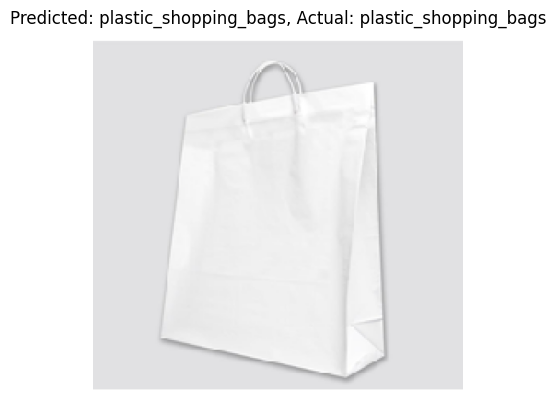

In [31]:
import random
from tensorflow.keras.preprocessing import image

# Load the best model
best_model = tf.keras.models.load_model("saved_models/DenseNet201.keras")

# Select a random image from the test data
x_test_batch, y_test_batch = next(test_data)
random_index = random.randint(0, len(x_test_batch) - 1)
random_image = x_test_batch[random_index]
random_label = np.argmax(y_test_batch[random_index])

# Predict
prediction = best_model.predict(np.expand_dims(random_image, axis=0))
predicted_class = class_names[np.argmax(prediction)]

# Display the image and prediction
plt.imshow(random_image)
plt.title(f"Predicted: {predicted_class}, Actual: {class_names[random_label]}")
plt.axis("off")
plt.show()


In [32]:


# Ensure consistent input shape
x_test, y_test = next(iter(test_data))
x_test_tensor = tf.convert_to_tensor(x_test)

# Predict
y_pred = np.argmax(best_model.predict(x_test_tensor), axis=1)
y_true = np.argmax(y_test, axis=1)

# Display results
results = [f"Predicted: {class_names[pred]} | Actual: {class_names[true]}" for pred, true in zip(y_pred, y_true)]
print(" | ".join(results[:10]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Predicted: disposable_plastic_cutlery | Actual: disposable_plastic_cutlery | Predicted: cardboard_boxes | Actual: cardboard_packaging | Predicted: aluminum_food_cans | Actual: aluminum_food_cans | Predicted: plastic_cup_lids | Actual: plastic_food_containers | Predicted: glass_cosmetic_containers | Actual: glass_cosmetic_containers | Predicted: newspaper | Actual: shoes | Predicted: food_waste | Actual: food_waste | Predicted: magazines | Actual: magazines | Predicted: plastic_trash_bags | Actual: plastic_trash_bags | Predicted: plastic_shopping_bags | Actual: plastic_shopping_bags


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


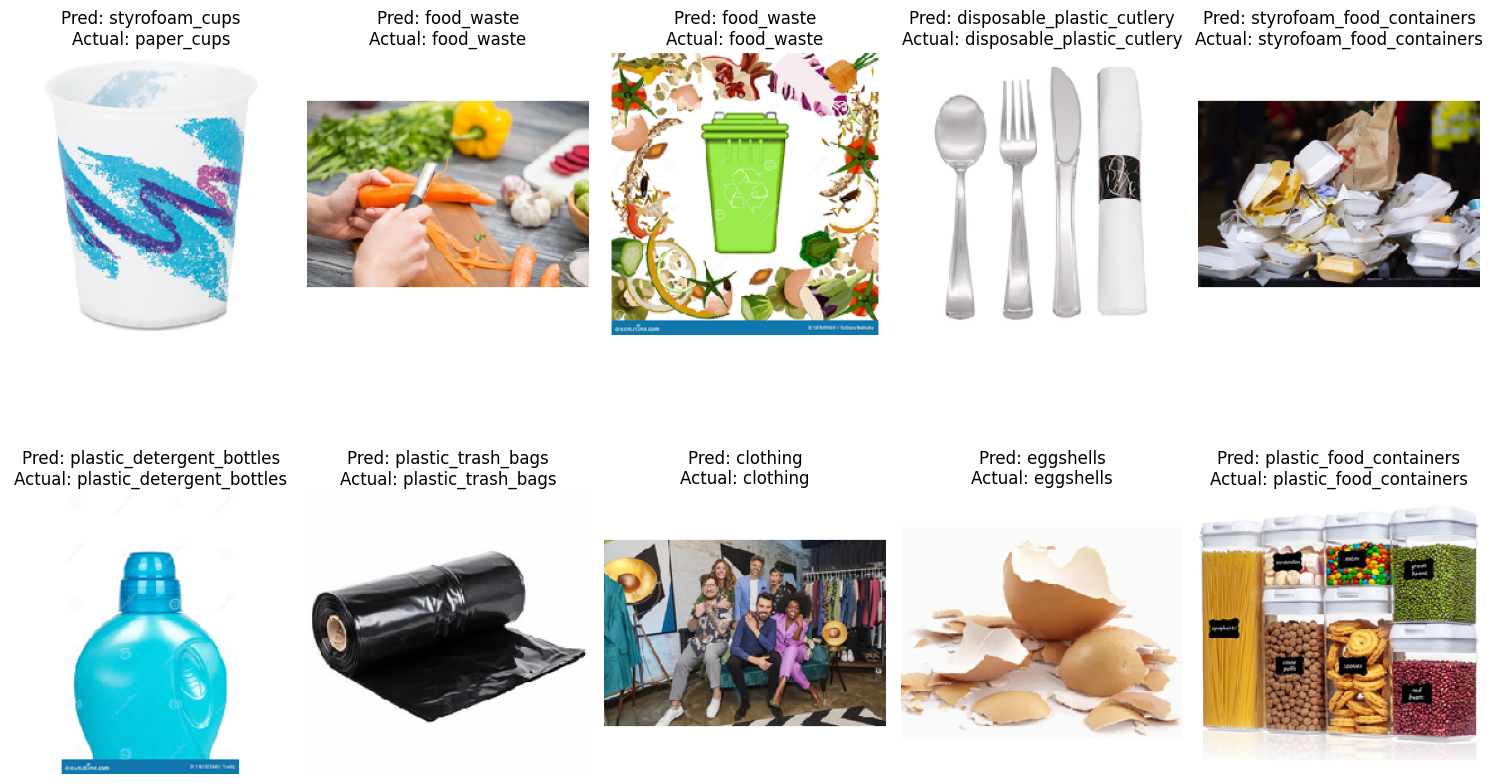

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images and labels from test data
x_test, y_test = next(iter(test_data))

# Predict using the best model
y_pred = np.argmax(best_model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Plot images with predictions
plt.figure(figsize=(15, 10))
for i in range(10):  # Display 10 images
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[i])
    plt.title(f"Pred: {class_names[y_pred[i]]}\nActual: {class_names[y_true[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


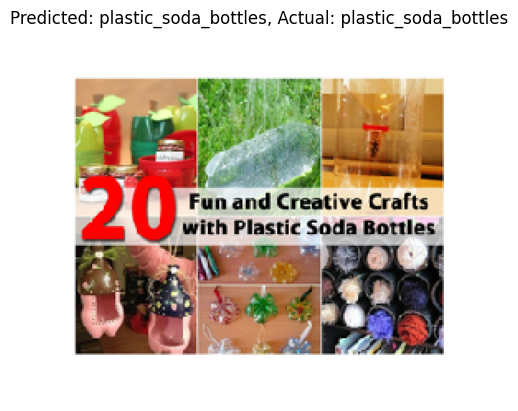

In [34]:
import random
from tensorflow.keras.preprocessing import image

# Load the best model
best_model_rs = tf.keras.models.load_model("saved_models/ResNet50V2.keras")

# Select a random image from the test data
x_test_batch, y_test_batch = next(test_data)
random_index = random.randint(0, len(x_test_batch) - 1)
random_image = x_test_batch[random_index]
random_label = np.argmax(y_test_batch[random_index])

# Predict
prediction = best_model_rs.predict(np.expand_dims(random_image, axis=0))
predicted_class = class_names[np.argmax(prediction)]

# Display the image and prediction
plt.imshow(random_image)
plt.title(f"Predicted: {predicted_class}, Actual: {class_names[random_label]}")
plt.axis("off")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


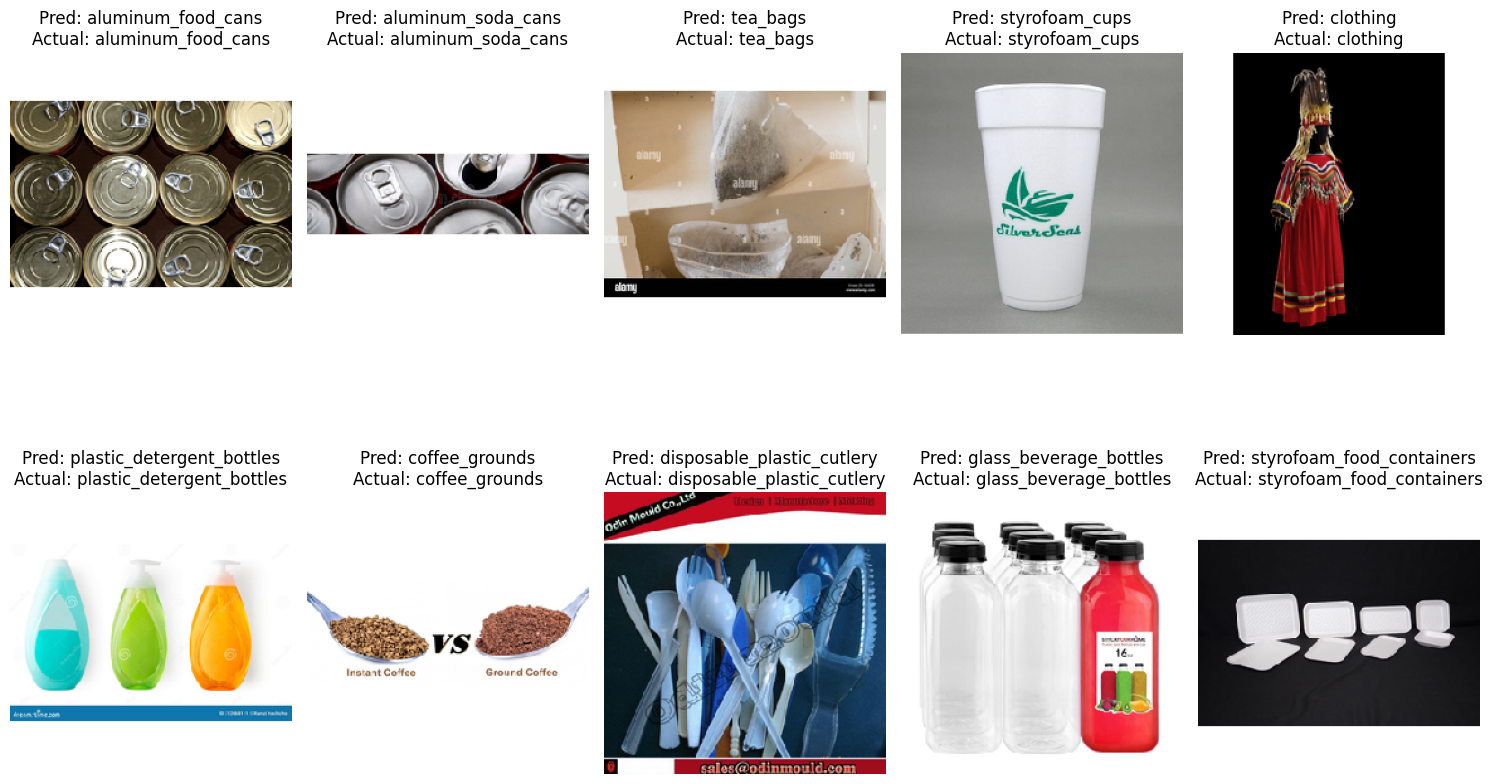

In [38]:


# Get a batch of images and labels from test data
x_test, y_test = next(iter(test_data))

# Predict using the best model
y_pred = np.argmax(best_model_rs.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Plot images with predictions
plt.figure(figsize=(15, 10))
for i in range(10):  # Display 10 images
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[i])
    plt.title(f"Pred: {class_names[y_pred[i]]}\nActual: {class_names[y_true[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()